In [1]:
import phylonetwork as pn

net = pn.PhylogeneticNetwork(eNewick='((D[&Theta=0.015]:0.01034,(C[&Theta=0.005]:0.0098)#H1[&Theta=0.995,&gamma=0.4051]:4.9969E-4)[&Theta=0.005]:0.04069,(A[&Theta=0.005]:0.0339,(#H1[&Theta=0.005]:0.00489,B[&Theta=0.005]:0.01474)S4[&Theta=0.005]:0.01918)[&Theta=0.005]:0.01710);')

In [2]:
import numpy as np
import scipy.stats as sps
from scipy.special import beta
import scipy.integrate as integrate

def nodes_to_spectral(f,N):
    f1 = np.reshape(f,(len(f),1)) #Need input as a column vector
    f2 = np.reshape(np.flip(f[1:-1], axis = 0),(len(f)-2,1)) #Need to make some alteration before we apply the inverse FFT 
    f = np.real(np.fft.ifft(np.append(f1,f2))) #Apply the inverse fourier transform and throw away the complex values 
    spectral_coefficients = np.append(f[0], 2*f[1:N]) #Get the Chebyshev coefficients
    spectral_coefficients = np.append(spectral_coefficients, f[N])
    return spectral_coefficients

def ClenshawCurtis_v2(c,N):
    integral = 0    
    for k in range(0,int(N/2)):
        integral += (2*c[2*k])/(1-4*k**2)
    return integral/2

def spectral_to_nodes(c,N):
    c = np.reshape(c,(len(c),1)) #This is to get a column vector, since the fourier transform output depends on the orientation
    cc = np.append(c[1:],np.flip(c[1:-1], axis = 0))/2 #Need to make some changes in order to get the Chebyshev coefficients
    ap = np.append(c[0], cc)#Apply the FFT and throw away the complex values
    F=np.real(np.fft.fft(ap))
    function_values=F[0:N] 
    return function_values

def fast_root_solver(λf):
    '''Get the Chebychev coefficients of g(x) where f(x) = x(1-x)g(x)  '''
    λg_even = uband_solver_2(λf[2::2])
    λg_odd = uband_solver_2(λf[3::2])
    λg = np.zeros(len(λg_odd) + len(λg_even))
    '''Sorry for the vector usage, but we are just splicing the solution back together sol_even = [ e e ... e e]
        sol_odd = [ o o ... o o] , then we have sol = [e o e o ... e o e o]'''
    λg[0::2] = λg_even
    λg[1::2] = λg_odd
    #print("sol",sol)
    return λg

def uband_solver_2(λ1):
    '''Backward subsitution for an upper matrix diagonal matrix w. upperband 2 (not general)  '''
    n = len(λ1)
    λ2 = np.zeros(n)
    λ2[-1] = -16*λ1[-1]
    λ2[-2] = -16*((-1/8)*λ2[-1]+ λ1[-2])
    for i in range(n-3, -1, -1):    
        λ2[i] = -16*((-1/8)*λ2[i+1] + (1/16)*λ2[i+2] + λ1[i])  
    if n % 2 == 0:
        λ2[0] = -8*((-1/8)*λ2[1] + (1/16)*λ2[2] + λ1[0])
    return λ2

def get_Chebypoints(N):
    xx = N
    circle = -np.arange(0,np.pi+np.pi/(xx-1),np.pi/(xx-1))
    #print("circle=", circle)
    x = (np.cos(circle) + 1)/2
    return x    
 
def integrate_root(α,β,λ):
#Compute integral at the root of a tree,\int f(x)beta(α,β) = \int (x(1-x)g(x) +rT_0 + sT_1)beta(α,β)
    root_int = 0
    A = 1/beta(α,β)
    λg = fast_root_solver(λ)
    pg =  spectral_to_nodes(λg,N-2)
    x = get_Chebypoints(N-2)
    pab = (x**α)*((1-x)**β)
    pr = pab*pg
    λp = nodes_to_spectral(pr,N-2)
    ####
    #plt.plot(x,pab)
    #plt.show()
    #plt.plot(x,pr)
    #p = np.arange(0,1,0.01)
    #g_plot = ch.chebval((2*p-1), λp)
    #plt.plot(p,g_plot)
    #plt.show()
    ####
    #print("Python Quadrature") 
    #f = lambda x: ch.chebval(2*x-1, λp)
    #print(A*integrate.quad(f, 0, 1)[0])
    root_int += A*ClenshawCurtis_v2(λp,N-2)
    #print("Clenshaw Quadrature")
    #print(root_int)
    s = λ[0]-(1/8)*λg[0]+(1/16)*λg[2] 
    root_int += s
    #print(s)
    r = λ[1]-(1/16)*λg[1]+(1/16)*λg[3]
    root_int += r*(2*α/(α+β)-1)
    #print(r*(2*α/(α+β)-1))
    return root_int

N= 9
beta_1 = 0.005
beta_2 = 0.005

x = get_Chebypoints(N)
root_f = 0.009*x**16
λ = nodes_to_spectral(root_f,N)

print(integrate_root(beta_2,beta_1,λ))

f = lambda p: (0.009*p**16)*(sps.beta.pdf(p,beta_1,beta_2))
exact = integrate.quad(f, 0, 1)
print(exact)

0.004471881416087675
(0.004426216539776829, 1.1815516059478226e-08)


In [3]:
#################################################################################
# Network Simulator
#################################################################################
from phylonetwork import NetworkShape, PhylogeneticNetwork
import random
from itertools import combinations
import numpy as np

def speciate(net: NetworkShape, u):
    result = net.copy()
    v = next(result.predecessors(u))
    w = result.make_elementary_node(v, u)
    up = result.new_node()
    result.add_edge(w, up)
    result.clear_cache()
    return result


def hybridize(net: NetworkShape, u1, u2):
    result = net.copy()
    v1 = next(result.predecessors(u1))
    v2 = next(result.predecessors(u2))
    w1 = result.make_elementary_node(v1, u1)
    w2 = result.make_elementary_node(v2, u2)
    h = result.new_reticulation_node()
    l = result.new_node()
    result.add_edges_from([(w1, h), (w2, h), (h, l)])
    result.clear_cache()
    return result


def random_combination(base, r):
    result = set()
    while len(result) != r:
        result = set()
        for _ in range(r):
            result.add(random.choice(base))
    return tuple(result)

def random_yule_btctc_generator(taxa, p):
    ntaxa = len(taxa)
    while True:
        net = PhylogeneticNetwork()
        r = net.new_node()
        u = net.new_node()
        v = net.new_node()
        net.add_edges_from([(r, u), (r, v)])
        for _ in range(ntaxa - 2):
            if random.random() < p:
                # make speciate
                u = random.choice(list(net.leaves))
                net = speciate(net, u)
            else:
                # make hybridize
                u, v = random_combination(list(net.leaves), 2)
                net = hybridize(net, u, v)
        leaves = list(net.leaves)
        random.shuffle(taxa)
        for (leaf, taxon) in zip(leaves, taxa):
            net.nodes[leaf]['label'] = taxon
        yield net
        
def random_network_generator(taxa, p):
    ntaxa = len(taxa)
    if ntaxa == 0:
        return None
    if ntaxa == 1:
        return PhylogeneticNetwork(eNewick=f"{taxa[0]};")
    if ntaxa == 2:
        return PhylogeneticNetwork(eNewick=f"({taxa[0]},{taxa[1]});")
    if (ntaxa > 2):
        net = PhylogeneticNetwork()
        r = net.new_node()
        u = net.new_node()
        v = net.new_node()
        net.add_edges_from([(r, u), (r, v)])
        for _ in range(ntaxa - 2):
            if random.random() < p:
                # make speciate
                u = random.choice(list(net.leaves))
                net = speciate(net, u)
            else:
                # make hybridize
                u, v = random_combination(list(net.leaves), 2)
                net = hybridize(net, u, v)
        leaves = list(net.leaves)
        random.shuffle(taxa)
        for (leaf, taxon) in zip(leaves, taxa):
            net.nodes[leaf]['label'] = taxon
        return net


#################################################################################
# Rules for SnapperNET
#################################################################################
def generate_cheby_lobatto_points():
    circle = -np.arange(0,np.pi+np.pi/(N-1),np.pi/(N-1))
    x = (np.cos(circle) + 1)/2
    return x

def rule_1_calc(c, t, L):
    coeff_top = go_to_top_of_branch(c, t, L)
    return coeff_top

def rule_2_calc(coeff_1,coeff_2):
    return multiply_likelihoods(coeff_1,coeff_2)
     
def rule_3_calc(c):
    x = generate_cheby_lobatto_points()
    matrix_y = np.zeros((N, N))
    matrix_z = np.zeros((N, N))
    for i in range(N):
            matrix_y[i,:] =  x
            matrix_z[:,i] =  x
    matrix_x = ch.chebval( (rho) * matrix_y  + (1-rho) * matrix_z, c)
    #tensor_x = t.tensor(matrix_x, names=(['y', 'z']))
    return matrix_x.flatten(order='C')

def rule_4_calc(tensor):
    
    # Convert to function values
       
    
    # Get the shape of the tensor
    shape = tensor.shape

    # Check if the tensor has at least two dimensions
    if len(shape) < 2:
        raise ValueError("Tensor must have at least two dimensions")

    # Get the last two dimensions
    last_two_dims = shape[-2:]

    # Create a mask for selecting the diagonal elements
    mask = torch.eye(last_two_dims[0], last_two_dims[1], dtype=torch.bool)
    
    
    # Apply the mask to the tensor
    diagonal_elements = tensor[..., mask]

    return diagonal_elements

def rule_5_calc(c):
    return integrate_root(beta_2,beta_1,c)

def permute_named_tensor_dimension(tensor, dim_name):
    # Get the current dimension names
    dim_names = tensor.names
    # Find the index of the specified dimension
    dim_index = dim_names.index(dim_name)
    tensor = tensor.rename(None)
    # Permute the dimensions, moving the specified dimension to the last position
    permuted_tensor = tensor.permute(*range(dim_index), *range(dim_index + 1, tensor.ndim), dim_index)
    # Update the dimension names
    permuted_dim_names = dim_names[:dim_index] + dim_names[dim_index + 1:] + (dim_name,)
    permuted_tensor = permuted_tensor.refine_names(*permuted_dim_names)
    
    return permuted_tensor

def permute_named_tensor_dimensions(tensor, dim_names_to_move_last):
    # Get the current dimension names
    dim_names = tensor.names

    # Find the indices of the specified dimensions
    dim_indices_to_move_last = [dim_names.index(dim_name) for dim_name in dim_names_to_move_last]

    # Permute the dimensions, moving the specified dimensions to the last positions
    last_indices = [i for i in range(tensor.ndim) if i not in dim_indices_to_move_last] + dim_indices_to_move_last
    tensor = tensor.rename(None)
    permuted_tensor = tensor.permute(*last_indices)

    # Update the dimension names
    permuted_dim_names = [dim_names[i] for i in last_indices]
    permuted_tensor = permuted_tensor.refine_names(*permuted_dim_names)

    return permuted_tensor

def apply_rule_1(node, parent):
    pl = get_partial_likelihood(node)
    dim_names = list(pl.value.names)
    
    if node in dim_names:
        pl.value = permute_named_tensor_dimension(pl.value, node)

    else:
        pl.value = permute_named_tensor_dimension(pl.value, parent)     
    
    pl.value = pl.value.rename(None)
    output = np.array([])
    pl_flat = pl.value.flatten()
    parts = np.split(pl_flat, len(pl_flat)/N)
    
    #GET BRANCH PARAMETERS
    branch_length = get_branch_length(node, parent)
    edge = get_edge(node, parent)
    
    for part in parts:
        output = np.append(output, rule_1_calc(part, branch_length, edge.L))
    
    pl_top = torch.tensor(output.reshape(pl.value.shape), names = dim_names)
    pl.value = pl_top
    
    return pl_top

def apply_rule_2(node):
    children = get_children(node)
    
    pl_1 = get_partial_likelihood(children[0])
    dim_names_1 = list(pl_1.value.names)    

    if node in dim_names_1:
        pl_1.value = permute_named_tensor_dimension(pl_1.value, node)
    else:
        pl_1.value = permute_named_tensor_dimension(pl_1.value, children[0])
        
    dim_names_1 = list(pl_1.value.names)
    pl_1.value = pl_1.value.rename(None)
    pl_flat_1 = np.array(pl_1.value.flatten())
    parts_1 = np.split(pl_flat_1, len(pl_flat_1)/N)
    pl_1.value = pl_1.value.rename(*dim_names_1)
    
    pl_2 = get_partial_likelihood(children[1])
    dim_names_2 = list(pl_2.value.names)
    if node in dim_names_2:
        pl_2.value = permute_named_tensor_dimension(pl_2.value, node)
    else:
        pl_2.value = permute_named_tensor_dimension(pl_2.value, children[1])   
    dim_names_2 = list(pl_2.value.names)
    pl_2.value = pl_2.value.rename(None)
    pl_flat_2 = np.array(pl_2.value.flatten())
    parts_2 = np.split(pl_flat_2, len(pl_flat_2)/N)
    pl_2.value = pl_2.value.rename(*dim_names_2)
    
    output = np.array([])
    for part_1 in parts_1:
        for part_2 in parts_2:
            output = np.append(output, rule_2_calc(part_1, part_2))
    
    size = [N] * int( np.log(len(output)) / np.log(N) )
    new_shape = torch.Size(size)
    
    #!!!still need to figure out how to arrange the dimensions given tghe above flatten procedure!!!
    dim_names = dim_names_1[:-1] + dim_names_2[:-1] + [node]
    
    pl_bottom = torch.tensor(output.reshape(new_shape), names = dim_names)
    pl_1.value = pl_bottom 
    pl_1.likelihood_front = pl_1.likelihood_front + pl_2.likelihood_front + [node]
    pl_2.likelihood_front = []
    
    
    return pl_bottom       

def apply_rule_3(node):
    child_node = get_children(node)[0]
    pl = get_partial_likelihood(child_node)
    pl.value = permute_named_tensor_dimension(pl.value, child_node)
    output = np.array([])
    dim_names = list(pl.value.names)
    pl.value = pl.value.rename(None)
    pl_flat = pl.value.flatten()
    parts = np.split(pl_flat, len(pl_flat)/N)
    
    for part in parts:
        output = np.append(output, rule_3_calc(part))
    
    ouput = torch.tensor(output)
    new_shape = tuple(list(pl.value.shape) + [N])
    
    for parent in get_parents(node):
        dim_names.append(parent) 
        
    dim_names.remove(child_node)
    
    pl_bottom = torch.tensor(output.reshape(new_shape), names = dim_names)
    pl.value = pl_bottom
    pl.likelihood_front.append(node)
    
    return pl_bottom

def apply_rule_4(node):
    
    children = get_children(node)
    pl = get_partial_likelihood(children)
    
    dim_names = list(pl.value.names)
    
    if node in dim_names:    
        dims_to_permute = [item for item in children if '#' not in str(item)]
        dims_to_permute.append(node)
        pl.value = permute_named_tensor_dimensions(pl.value, dims_to_permute)
    else:
        pl.value = permute_named_tensor_dimensions(pl.value, children)
    
    dim_names = list(pl.value.names)
    pl.value = pl.value.rename(None)

    tensor = rule_4_calc(pl.value)
    dim_names = (dim_names[:-2] + [node]) 
    pl.value = tensor.refine_names(*dim_names)
     
    pl.likelihood_front.append(node)
 
    return pl

def apply_rule_5(node):
    pl = get_partial_likelihood(node) 
    pl.value = rule_5_calc(pl.value)
    pl.likelihood_front.append(node)
    return pl.value

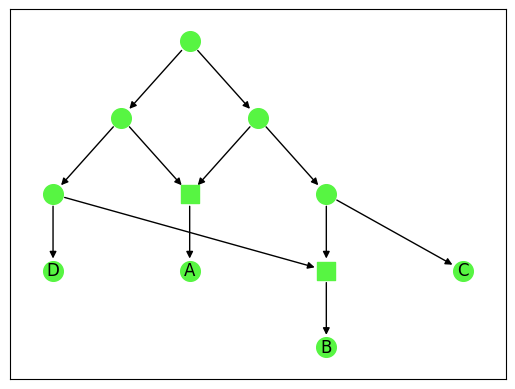

node  _9  Population size set to 0.005
child  _9  parent #2 branch length set to  0.1
node  #2  Population size set to 0.005
node  #2  Reticulation parameter set to  0.5
child  #2  parent _7 branch length set to  0.1
child  #2  parent _8 branch length set to  0.1
node  _2  Population size set to 0.005
child  _2  parent _8 branch length set to  0.1
node  _6  Population size set to 0.005
child  _6  parent #1 branch length set to  0.1
node  _3  Population size set to 0.005
child  _3  parent _7 branch length set to  0.1
node  _8  Population size set to 0.005
child  _8  parent _5 branch length set to  0.1
node  #1  Population size set to 0.005
node  #1  Reticulation parameter set to  0.5
child  #1  parent _4 branch length set to  0.1
child  #1  parent _5 branch length set to  0.1
node  _7  Population size set to 0.005
child  _7  parent _4 branch length set to  0.1
node  _5  Population size set to 0.005
child  _5  parent _1 branch length set to  0.1
node  _4  Population size set to 0.005
chi

In [8]:
%matplotlib inline
import numpy as np
import phylonetwork as pn
import scipy.integrate as integrate
import scipy as sp
import scipy.stats as sps
import numpy as np
import numpy.polynomial.chebyshev as ch
from numpy.linalg import inv
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as ch
from scipy.integrate import simps
import collections as c
import pandas as pd
import networkx as nx
import torch
#################################################################################
# Caratheodory-Fejer Implementation
#################################################################################
#Global variables
c_real = np.array([0.000818433612497,-0.068571505514864,1.319411815998137
,-8.238258033274786,18.785982629476070,-11.799383335697918,-11.799383335697890
,18.785982629476067,-8.238258033274763,1.319411815998138,-0.068571505514865
,0.000818433612497])
c_imag = np.array([0.000581353207069,-0.038419074245887,0.183523497750480
,2.796192505614474,-20.237292093573895,46.411650777279597,-46.411650777279569
,20.237292093573895,-2.796192505614448,-0.183523497750480,0.038419074245888
,-0.000581353207069])
z_real = np.array([-6.998688082445778,-2.235968223749446,0.851707264834878
,2.917868800307170,4.206124506834328,4.827493775040721,4.827493775040721
,4.206124506834328,2.917868800307170,0.851707264834878,-2.235968223749446
,-6.998688082445778])
z_imag = np.array([-13.995917029301355,-11.109296400461870,-8.503832905826961
,-6.017345968518187,-3.590920783130140,-1.193987999180278,1.193987999180278
,3.590920783130140,6.017345968518187,8.503832905826961,11.109296400461870
,13.995917029301355])
c = c_real + 1j*c_imag
z = z_real + 1j*z_imag
#Functions
def get_values_tridag(LL,AA,A2c,c_i,z_i):
    a = np.array([])
    b = np.array([])
    c = np.array([])
    d = np.array([])
    b = np.append(b, AA[1,1])
    c = np.append(c, AA[1,3])
    d = np.append(d, A2c[1])
    for i in range(2,N-2):
        if (i % 2 == 1):
            a = np.append(a, AA[i,i-2])     
            b = np.append(b, AA[i,i]) 
            c = np.append(c, AA[i,i+2])
            d = np.append(d, A2c[i])
    d = np.append(d, A2c[N-2])
    a = np.append(a, AA[N-2,N-4])
    b = np.append(b, AA[N-2,N-2])
    return a, b, c, d

def get_values_uband(LL,AA,A2c,c_i,z_i):
    a = np.array([])
    b = np.array([])
    c = np.array([])
    d = np.array([])
    for i in range(1,N-1):
        if (i % 2 == 0):
            a = np.append(a, AA[i,i-2])     
            b = np.append(b, AA[i,i]) 
            c = np.append(c, AA[i,i+2])
            d = np.append(d, A2c[i])
    
    a = np.append(a, (LL-np.identity(N)*z_i)[N-3,N-3])
    a = np.append(a, (LL-np.identity(N)*z_i)[N-1,N-1])
    b = np.append(b, (LL-np.identity(N)*z_i)[N-3,N-1])
    d = np.append(d, c_i[N-3])
    d = np.append(d, c_i[N-1])
    return a, b, c, d

def expM_CF_faster(Q,v,LL,branch_length,delta_t):   
    w = np.zeros([len(c_real),len(v)],dtype=complex)
    x = np.zeros([len(v)],dtype=complex)
    w[0,:] = v
    for t in range(0,int(branch_length/delta_t)): 
        vi = np.sum(w,axis=0)
        for i in range(0,len(c_real)):
            x = faster_solver(LL,Q-(z[i]/delta_t)*A2,np.dot(A2,vi/delta_t),vi/delta_t,z[i]/delta_t)
            w[i] = x*c[i]                             
    return(w)

def faster_solver(LL,AA,A2c,c_i,z_i):
    uband = get_values_uband(LL,AA,A2c,c_i,z_i)
    #print("uband", uband)
    sol_even = uband_solver(uband[0],uband[1],uband[2],uband[3])
    #print("sol_even", sol_even)
    triband = get_values_tridag(LL,AA,A2c,c_i,z_i)
    #print("triband", triband)
    sol_odd = tridag_solver(triband[0],triband[1],triband[2],triband[3])
    #print("sol_odd", sol_odd)
    sol = np.zeros(len(sol_odd) + len(sol_even), dtype = complex)
#Sorry for the vector usage, but we are just splicing the solution back together sol_even = [ e e ... e e]
# sol_odd = [ o o ... o o] , then we have sol = [e o e o ... e o e o]
    sol[0::2] = sol_even
    sol[1::2] = sol_odd
    #print("sol",sol)
    return sol

def uband_solver(a,b,c,d):
    '''
    Backward subsitution for an upper matrix diagonal matrix w. upperband 1  '''
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    xc = dc
    xc[-1] = dc[-1]/ac[-1]
    xc[-2] = (dc[-2] - bc[-1]*xc[-1])/ac[-2]
    for il in range(nf-3, -1, -1):
        xc[il] = (dc[il] - bc[il]*xc[il+1]- cc[il]*xc[il+2])/ac[il]        
    return xc
## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def tridag_solver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

#################################################################################
# Matrix operators
#################################################################################
def Aint(N): #Integral operator
    I = sp.sparse.diags([0.5, 0, 0.5], [-1, 0, 1], shape=(N, N)).toarray()
    I[np.arange(2,N,1)-1,np.arange(2,N,1)] = -1/(np.arange(2,N,1)-1)*I[np.arange(2,N,1)-1,np.arange(2,N,1)]
    I[np.arange(2,N-1,1)+1,np.arange(2,N-1,1)] = 1/(np.arange(2,N-1,1)+1)*I[np.arange(2,N-1,1)+1,np.arange(2,N-1,1)]
    I = 1/2*I
    I[0,0] = 0
    I[0,1] = 0
    I[1,0] = 1/2
    I[2,1] = 1/8
    return I

def x_times_Tx(N): #Transpose of Operator B defined as x*f(x) (Gordon's thesis Propositon.5 page. 78)
    B = sp.sparse.diags([0.25, 0.5, 0.25], [-1, 0, 1], shape=(N, N)).toarray()
    B[1,0] = 0.5
    return B

def Dd(N): #Derivative operator
    D = np.zeros([N,N])
    D[0,np.arange(1,N,2)] = 2*np.arange(1,N,2)
    for i in range(0,N-2):
        D[i+1,np.arange(i+2,N,2)] = 4*(np.arange(i+1,N-1,2)+1)
    return D

def compute_matrix_operator(u,v,theta):
   #selection and mutation    
    a = np.array([u,-(u+v),0,0])
    #genetic drift
    b = 1/theta * np.array([0,1,-1,0])
    #Assigning operators
    #4.5 Proposition 5 Operator B
    S = x_times_Tx(N)
    S2 = np.dot(S,S)
    S3 = np.dot(S2,S)
    #First Derivative       
    D = Dd(N)
    #Second Derivative
    D2 = np.dot(D,D)
    A = Aint(N)
    A2 = np.dot(A,A)
    LL = (a[0]*D) + (a[1]*np.dot(S,D)) + (a[2]*np.dot(S2,D)) + (a[3]*np.dot(S3,D))\
         + ((b[0]*D2) + (b[1]*np.dot(S,D2)) + (b[2]*np.dot(S2,D2))) 
    return LL

#################################################################################
# FFT forward and backward / Likelihood calcs
#################################################################################


def points_to_coeff(f):
    f1 = np.reshape(f,(len(f),1)) #Need input as a column vector
    f2 = np.reshape(np.flip(f[1:-1], axis = 0),(len(f)-2,1)) #Need to make some alteration before we apply the inverse FFT 
    f = np.real(np.fft.ifft(np.append(f1,f2))) #Apply the inverse fourier transform and throw away the complex values 
    spectral_coefficients = np.append(f[0], 2*f[1:N]) #Get the Chebyshev coefficients
    return spectral_coefficients

def coeff_to_points(c):
    c = np.reshape(c,(len(c),1)) #This is to get a column vector, since the fourier transform output depends on the orientation
    cc = np.append(c[1:],np.flip(c[1:-1], axis = 0))/2 #Need to make some changes in order to get the Chebyshev coefficients
    ap = np.append(c[0], cc)#Apply the FFT and throw away the complex values
    F=np.real(np.fft.fft(ap))
    function_values=F[0:N] 
    return function_values
        
def compute_leave_likelihood(n,m):
    x = generate_cheby_lobatto_points()
    f = sps.binom.pmf(m, n, x, loc=0)
    return f

def go_to_top_of_branch(pl,t, L):
    w = expM_CF_faster(np.dot(A2,L),pl,L,t,0.005)
    return (np.real(np.sum(w, axis=0)))

def generate_cheby_lobatto_points():
    circle = -np.arange(0,np.pi+np.pi/(N-1),np.pi/(N-1))
    x = (np.cos(circle) + 1)/2
    return x


def multiply_likelihoods(coeff_1,coeff_2):
    #get chebyshev lobatto points
    points_1 =  coeff_to_points(coeff_1)
    points_2 = coeff_to_points(coeff_2)
    return points_to_coeff(points_1*points_2)

#################################################################################
# General network functions
#################################################################################
class edge():
    def __init__(self, child, parent):
            self.bottom_node = child
            self.top_node = parent
            self.L = compute_matrix_operator(u,v, float(net.nodes[self.bottom_node]['metadata']['Theta']))            
    def describe(self):
        return "bottom node is " + self.bottom_node + "; top node is " + self.top_node

class partial_likelihood():
    def __init__(self, node):
            self.likelihood_front = [node]
            self.value = torch.tensor([], names=tuple({node}))
    def describe(self):
        return "likelihood front contains the following nodes" + self.likelihood_front

def classify_nodes(net):
    
    for node in net.bottom_to_top_nodes:
        net.nodes[node]['reticulation_lca'] = False
        net.nodes[node]['reticulation_lca_count'] = 0
    
    for node in net.bottom_to_top_nodes:
        if(net.is_reticulation(node)):
            net.nodes[node]['type'] = "reticulation"
            parents = get_parents(node)
            lca = nx.lowest_common_ancestor(net, parents[0],parents[1])
            net.nodes[lca]['reticulation_lca'] = True
            net.nodes[lca]['reticulation_lca_count'] += 1 
            
        elif(net.is_leaf(node)):    
            net.nodes[node]['type'] = "leaf"         
        elif(net.is_root(node)):
            net.nodes[node]['type'] = "root"
        elif(net.is_tree_node(node)):
            net.nodes[node]['type'] = "tree"

    for node in net.bottom_to_top_nodes:
        print(net.nodes[node])

def compute_likelihood_at_leaves(snp_df):    
    for leave in net.leaves:
        taxa = net.labeling_dict[leave]
        n = snp_df[snp_df.sample_label==taxa]["n"].iloc[0]
        r = snp_df[snp_df.sample_label==taxa]["r"].iloc[0]
        partial_likelihood  =  get_partial_likelihood(leave)
        partial_likelihood.value = torch.tensor(compute_leave_likelihood(n,r), names=tuple({leave}))
            
#Get length of branch as specified in parser
def get_branch_length(child,parent):
    return net.edges[parent, child]['length']

#Returns Node numbers (not labels) as vector of strings
def get_parents(child):
    a_dict = net.predecessors(child)
    parents = list()
    for key in a_dict:
        parents.append(key)
    return parents

def get_children(parent):
    a_dict = net.successors(parent)
    children = list()
    for key in a_dict:
        children.append(key)
    return children

def get_edge(bottom_node, top_node):
    output = next((x for x in edges if ((x.bottom_node == bottom_node) & (x.top_node == top_node))), None) 
    return output

def get_partial_likelihood(nodes):
    if type(nodes) == str: nodes = [nodes]
    return next((x for x in partial_likelihoods if (set(nodes).issubset(x.likelihood_front))), None) 

def set_reticulation_parameter(rho):
    net.nodes[node]['metadata']['gamma'] = rho
    print("node ", node, " Reticulation parameter set to ", rho)
    
def set_population_size(node, pop_size):
    net.nodes[node]['metadata']['Theta'] = pop_size
    print("node ", node," Population size set to", pop_size)

def set_branch_length(child,parent, length):
    net.edges[parent, child]['length'] = length
    print("child ", child," parent",parent,"branch length set to ", length)

def get_branch_length(child,parent):
    return net.edges[parent, child]['length']    
    
#################################################################################
# Initialize network
#################################################################################
#GLOBAL VARIABLES 
N = 9
A = Aint(N)
A2 = np.dot(A,A)
#INPUT
u = 1
v = 1
#net = pn.PhylogeneticNetwork(eNewick='((A[&Theta=0.005]:0.02,(B[&Theta=0.005]:0.015)#H1[&Theta=0.005,gamma=0.5]:0.005)\
#                                    S1[&Theta=0.005]:0.01,(#H1[&Theta=0.005,gamma=0.5]:0.005,\
#                                    C[&Theta=0.005]:0.02)S2[&Theta=0.005]:0.01)[&Theta=0.005];')


taxa = np.array(['A', 'B', 'C', 'D'])
p = 0.01
net = random_network_generator(taxa,p)
net.draw()

for node in net.bottom_to_top_nodes:
    net.nodes[node]['metadata'] ={}
    set_population_size(node , 0.005)
    if net.is_reticulation(node):
        set_reticulation_parameter(0.5)             
    parents = get_parents(node)
    #Iterate over edges
    for parent in parents:
        set_branch_length(node,parent, 0.1)



snp_input = [{'sample_label':'A', 'n': 10 , 'r': 4}, 
            {'sample_label':'B', 'n': 12 , 'r': 2}, 
            {'sample_label':'C', 'n': 6 , 'r': 3},
            {'sample_label':'D', 'n': 6 , 'r': 3},
            {'sample_label':'E', 'n': 6 , 'r': 3},
            {'sample_label':'F', 'n': 6 , 'r': 3}]
df_snp = pd.DataFrame(snp_input)
#Initialize the compute operators for each edge
edges = []
for node in net.bottom_to_top_nodes:
    parents = get_parents(node)
    for parent in parents:
        edges.append(edge(node,parent))

#Initialize partial likelihoods
partial_likelihoods = []
for leave in net.leaves:
    print(leave)
    partial_likelihoods.append(partial_likelihood(leave))
        
#################################################################################
# Compute likelihood
#################################################################################
classify_nodes(net)
compute_likelihood_at_leaves(df_snp)

#TEST PARTIAL LIKELIHOOD _INIT_
for leave in net.leaves:
    partial_likelihood = get_partial_likelihood(leave)

# --> STILL BUSY HERE

for node in net.bottom_to_top_nodes:
    parents = get_parents(node)
    #Iterate over edges
    for parent in parents:
        partial_likelihood = get_partial_likelihood(parent)  
            

In [9]:
'''
Iterate over nodes (with data) to test computation on reticulations
'''

for node in net.bottom_to_top_nodes:   
    #Iterate over edges // Add the leave computation
    print(node)
    if net.nodes(data=True)[node]['type'] == "leaf":
        parent_node = get_parents(node)
        apply_rule_1(node,parent_node[0])        
        
    if net.nodes(data=True)[node]['type'] == "tree":
        apply_rule_2(node) if get_partial_likelihood(get_children(node))==None else apply_rule_4(node)
        parent_node = get_parents(node)
        apply_rule_1(node,parent_node[0])
        
    if net.nodes(data=True)[node]['type'] == "reticulation":
        rho = float(net.nodes(data=True)[node]['metadata']['gamma'])
        apply_rule_3(node)
        parent_nodes = get_parents(node)
        for parent_node in parent_nodes:
            apply_rule_1(node,parent_node)

    if net.nodes(data=True)[node]['type'] == "root":
        apply_rule_2(node) if get_partial_likelihood(get_children(node))==None else apply_rule_4(node)
        apply_rule_5(node)

_9
#2
_2
_6
_3
_8
#1
_7
_5
_4
_1


In [6]:
print(net.nodes(data=True))

[('_1', {'metadata': {'Theta': 0.005}, 'reticulation_lca': True, 'reticulation_lca_count': 1, 'type': 'root'}), ('_2', {'label': 'B', 'metadata': {'Theta': 0.005}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'leaf'}), ('_3', {'label': 'C', 'metadata': {'Theta': 0.005}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'leaf'}), ('_4', {'metadata': {'Theta': 0.005}, 'reticulation_lca': True, 'reticulation_lca_count': 1, 'type': 'tree'}), ('_5', {'metadata': {'Theta': 0.005}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'tree'}), ('#1', {'metadata': {'Theta': 0.005, 'gamma': 0.5}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'reticulation'}), ('_6', {'label': 'A', 'metadata': {'Theta': 0.005}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'leaf'}), ('_7', {'metadata': {'Theta': 0.005}, 'reticulation_lca': False, 'reticulation_lca_count': 0, 'type': 'tree'}), ('_8', {'metadata': {'Theta': 0.005}, 're